In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [99]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 5 hours 55 mins
H2O cluster version:,3.10.4.8
H2O cluster version age:,5 months and 7 days !!!
H2O cluster name:,H2O_from_python_yumingfang_nxl75v
H2O cluster total nodes:,1
H2O cluster free memory:,3.197 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [126]:
df = pd.read_csv('/Users/yumingfang/Downloads/take-home_exercise_data.csv', index_col = 0)

In [11]:
df.head()

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
1,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0
2,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0
3,171965960,159656050,2016-11-25,Order prior to reg,New Reg,NaN,-1,Paid Search Non Brand,0,NaN
4,175522116,165370285,2017-03-08,<=60 days,Existing Reg,NaN,-1,Email Programs,0,NaN
5,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN


In [14]:
df.shape

(251942, 10)

In [37]:
set(df.daystogetresult_grp)

{'-1',
 '1 week',
 '10 weeks',
 '2 weeks',
 '3 weeks',
 '4 weeks',
 '5 weeks',
 '6 weeks',
 '7 weeks',
 '8 weeks',
 '9 weeks',
 '>10weeks'}

In [13]:
#check missing value
df.isnull().sum()

prospectid                      0
ordernumber                     0
ordercreatedate                 0
regtenure                       0
customer_type_group             0
dnatestactivationdayid      73097
daystogetresult_grp             0
dna_visittrafficsubtype     62849
xsell_gsa                       0
xsell_day_exact            211363
dtype: int64

### data cleaning and feature engineering
- create label for response variable: 0 if not a xseller, 1 is a xseller
- To predict the xseller, weeks between date DNA test is activated and date DNA order is created are generated and binned into several levels.  If never active the test, it will return -1
- The overall xseller rate is about 12%

In [127]:
# create label for xseller: 0: not a xseller; 1: xseller
def create_label(row):
    if row['xsell_gsa'] == 1 and row['xsell_day_exact'] <= 120:
        return 1
    else:
        return 0
df['xseller'] = df.apply(create_label, axis=1)

In [102]:
sum(df['xseller'] == 1)/float(df.shape[0])

0.12390153289249113

In [128]:
s = pd.to_datetime(df['dnatestactivationdayid']) - pd.to_datetime(df['ordercreatedate'])
df['week_diff'] = s.astype('timedelta64[W]')


In [129]:
def create_bin(x):
    if pd.isnull(x):
        return '-1'
    if x>= 0 and x <= 1:
        return '1 week'
    if x == 2:
        return '2 weeks'
    if x == 3:
        return '3 weeks'
    if x == 4:
        return '4 weeks'
    if x == 5:
        return '5 weeks'
    if x == 6:
        return '6 weeks'
    if x == 7:
        return '7 weeks'
    if x == 8:
        return '8 weeks'
    if x == 9:
        return '9 weeks'
    if x == 10:
        return '10 weeks'
    else:
        return '> 10 weeks'
    
df['week_diff'] = df['week_diff'].apply(lambda x: create_bin(x))


In [130]:
# remove not useful variables
df.drop(df[['prospectid', 'ordernumber', 'ordercreatedate', 'dnatestactivationdayid', 'xsell_gsa', 'xsell_day_exact' ]], axis=1, inplace=True)

### EDA
- The next step is to explore relationships between predict variables and response variable. First let's take a look at how customer type affect whether or not a Xseller
- It seems cusomters who are existing registrant have a much higher chance to become Xseller for Acom subscriptions.
- Next I am looking at the relationship between week difference of dateDNA test is activated and date DNA order is created and the whether or not a Xseller.
- It shows customers who activate the test within a week after they place the order have higher chance to become Xseller. In other words, customers who react fast after their DNA kit purchase are more likely to become Xseller

In [17]:
df_custype = df[['customer_type_group', 'xseller']].groupby('customer_type_group').mean()

,xseller
customer_type_group,
Acom Sub,0.032282
Existing Reg,0.181618
New Reg,0.151497


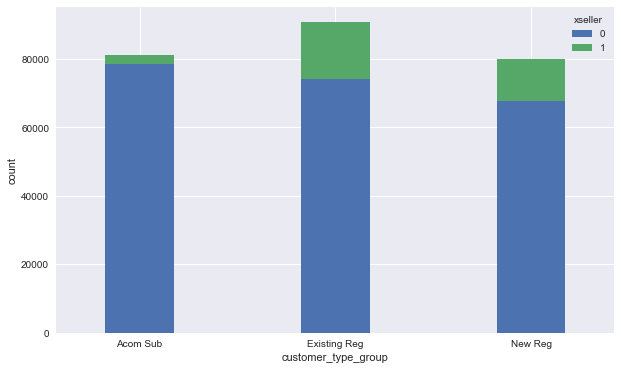

In [97]:
ct = pd.crosstab(df.customer_type_group, df.xseller)
ax = ct.plot.bar(stacked=True, width = 0.35)
plt.legend(title='xseller')
plt.ylabel('count')
for label in ax.get_xticklabels():
    label.set_rotation(0)
plt.show()

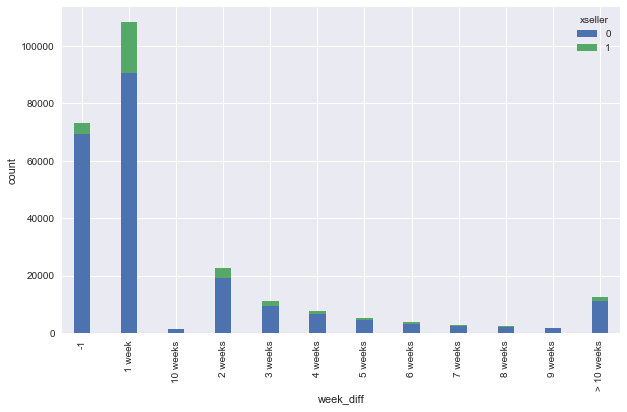

In [138]:
ct = pd.crosstab(df.week_diff, df.xseller)
ax = ct.plot.bar(stacked=True, width = 0.35)
plt.legend(title='xseller')
plt.ylabel('count')
xt = ['-1', '1 week', '2 weeks', '3 weeks', '4 weeks', '5 weeks', '6 weeks', '7 weeks', '8 weeks', '9 weeks',
     '10 weeks', '> 10 weeks']
#ax.set_xticks(xt)
plt.show()

In [76]:
df[['week_diff', 'xseller']].groupby('week_diff').mean()

,xseller
week_diff,
-1,0.053162
1 week,0.164765
10 weeks,0.121482
2 weeks,0.143080
3 weeks,0.147581
4 weeks,0.141277
5 weeks,0.144969
6 weeks,0.132381
7 weeks,0.141021


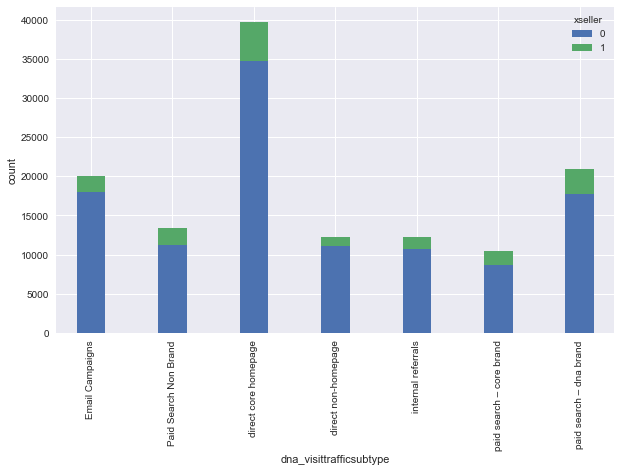

In [73]:
df_sub = df[df.dna_visittrafficsubtype.isin(['Email Campaigns', 'Paid Search Non Brand', 'direct core homepage', 'direct non-homepage',
                                           'internal referrals', 'paid search \xe2\x80\x93 core brand', 
                                             'paid search \xe2\x80\x93 dna brand'])]
ct = pd.crosstab(df_sub.dna_visittrafficsubtype, df_sub.xseller)
ct.plot.bar(stacked=True, width = 0.35)
plt.legend(title='xseller')
plt.ylabel('count')
plt.show()

In [75]:
df_sub[['dna_visittrafficsubtype', 'xseller']].groupby('dna_visittrafficsubtype').mean()

,xseller
dna_visittrafficsubtype,
Email Campaigns,0.101688
Paid Search Non Brand,0.162313
direct core homepage,0.123744
direct non-homepage,0.098145
internal referrals,0.127602
paid search – core brand,0.168729
paid search – dna brand,0.149534


In [150]:
week_bin = ['-1', '1 week', '2 weeks', '3 weeks', '4 weeks', '5 weeks', '6 weeks', '7 weeks', '8 weeks', '9 weeks',
     '10 weeks', '>10weeks']
mapping = {week: i for i, week in enumerate(week_bin)}
key = df['daystogetresult_grp'].map(mapping)
df_1 = df[['daystogetresult_grp', 'xseller']].iloc[key.argsort()]
df_1.groupby('daystogetresult_grp').mean()
#key.argsort()
#df[['daystogetresult_grp', 'xseller']].set_index('daystogetresult_grp').loc[week_bin].groupby('daystogetresult_grp').mean()

,xseller
daystogetresult_grp,
-1,0.071103
1 week,0.162562
10 weeks,0.167064
2 weeks,0.157210
3 weeks,0.150050
4 weeks,0.153910
5 weeks,0.166186
6 weeks,0.167924
7 weeks,0.163939


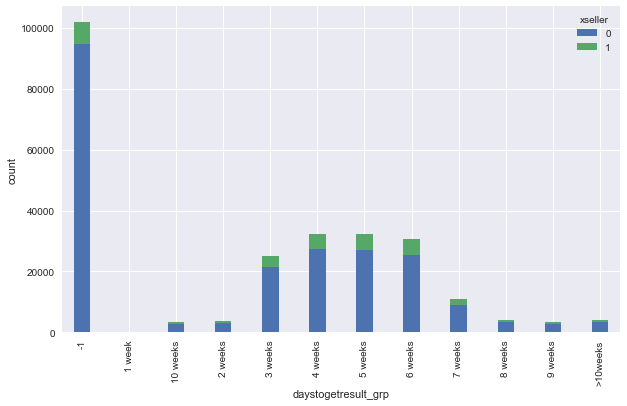

In [137]:
ct = pd.crosstab(df.daystogetresult_grp, df.xseller)
ax = ct.plot.bar(stacked=True, width = 0.35)
plt.legend(title='xseller')
plt.ylabel('count')
plt.show()

In [106]:
# load data into H2O object
df.to_csv('df_ancestry.csv')
df_model = h2o.import_file(path='df_ancestry.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [107]:
df_model = df_model.drop('C1')
df_model.describe()

Rows:251942
Cols:6




,regtenure,customer_type_group,daystogetresult_grp,dna_visittrafficsubtype,xseller,week_diff
type,enum,enum,enum,enum,int,enum
mins,,,,,0.0,
mean,,,,,0.123901532892,
maxs,,,,,1.0,
sigma,,,,,0.329469837609,
zeros,,,,,220726,
missing,0,0,0,62849,0,0
0,More than 120 days old,Existing Reg,4 weeks,,1.0,1 week
1,Order prior to reg,New Reg,4 weeks,,1.0,5 weeks
2,Order prior to reg,New Reg,-1,Paid Search Non Brand,0.0,-1


In [109]:
df_model['xseller'] = df_model['xseller'].asfactor()
myY = 'xseller'
myX = df_model.columns.remove('xseller')
rf = H2ORandomForestEstimator(nfolds = 3, seed = 1, ntrees = 10,
                    max_depth = 5,balance_classes = True)
rf.train(myX, myY, training_frame = df_model)        
rf

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1509147901958_411


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.339204111633
RMSE: 0.582412320983
LogLoss: 0.959276871191
Mean Per-Class Error: 0.29799510661
AUC: 0.743773023752
Gini: 0.487546047504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.075531579081: 


,0,1,Error,Rate
0,118235.0,100272.0,0.4589,(100272.0/218507.0)
1,34639.0,183798.0,0.1586,(34639.0/218437.0)
Total,152874.0,284070.0,0.3088,(134911.0/436944.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0755316,0.7315241,285.0
max f2,0.0283634,0.8392695,370.0
max f0point5,0.1411933,0.6919278,216.0
max accuracy,0.1123520,0.7019893,247.0
max precision,0.6043455,1.0,0.0
max recall,0.0057754,1.0,399.0
max specificity,0.6043455,1.0,0.0
max absolute_mcc,0.0977280,0.4124711,258.0
max min_per_class_accuracy,0.1853291,0.6894836,166.0
max mean_per_class_accuracy,0.1123520,0.7020049,247.0


Gains/Lift Table: Avg response rate: 12.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0128482,0.2691165,2.5980550,2.5980550,0.3219030,0.3219030,0.0333803,0.0333803,159.8054996,159.8054996
,2,0.0274468,0.2675251,2.5125637,2.5525833,0.3113105,0.3162690,0.0366799,0.0700602,151.2563707,155.2583274
,3,0.0385525,0.2651101,2.3624331,2.4978072,0.2927091,0.3094821,0.0262365,0.0962968,136.2433063,149.7807171
,4,0.0410174,0.2646694,2.3134053,2.4867259,0.2866345,0.3081092,0.0057022,0.1019990,131.3405281,148.6725927
,5,0.0507101,0.2628018,2.3201431,2.4548853,0.2874693,0.3041641,0.0224885,0.1244874,132.0143107,145.4885347
,6,0.1322130,0.2536392,2.1727902,2.2809874,0.2692120,0.2826178,0.1770887,0.3015761,117.2790217,128.0987377
,7,0.1500306,0.2477710,2.0622302,2.2550078,0.2555135,0.2793989,0.0367440,0.3383201,106.2230155,125.5007823
,8,0.2002167,0.2304064,2.0426258,2.2017723,0.2530845,0.2728030,0.1025115,0.4408316,104.2625793,120.1772322
,9,0.3118257,0.2078339,1.6710739,2.0118241,0.2070486,0.2492681,0.1865069,0.6273385,67.1073876,101.1824133
,10,0.4001159,0.1467928,1.3591839,1.8678116,0.1684050,0.2314247,0.1200026,0.7473411,35.9183855,86.7811571




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.0995426453757
RMSE: 0.315503796135
LogLoss: 0.331784588945
Mean Per-Class Error: 0.297947170608
AUC: 0.744164719635
Gini: 0.488329439269
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.188259592444: 


,0,1,Error,Rate
0,152122.0,68604.0,0.3108,(68604.0/220726.0)
1,9569.0,21647.0,0.3065,(9569.0/31216.0)
Total,161691.0,90251.0,0.3103,(78173.0/251942.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1882596,0.3564260,135.0
max f2,0.0942625,0.5270578,245.0
max f0point5,0.2268188,0.2933456,71.0
max accuracy,0.2782814,0.8759675,0.0
max precision,0.2724580,0.3128706,3.0
max recall,0.0125226,1.0,399.0
max specificity,0.2782814,0.9997282,0.0
max absolute_mcc,0.1281992,0.2680852,213.0
max min_per_class_accuracy,0.1895158,0.6907433,133.0
max mean_per_class_accuracy,0.1174825,0.7020528,226.0


Gains/Lift Table: Avg response rate: 12.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0113598,0.2724580,2.5239266,2.5239266,0.3127184,0.3127184,0.0286712,0.0286712,152.3926633,152.3926633
,2,0.0206913,0.2678132,2.3412892,2.4415594,0.2900893,0.3025129,0.0218478,0.0505190,134.1289223,144.1559368
,3,0.0302570,0.2670156,2.4279754,2.4372648,0.3008299,0.3019808,0.0232253,0.0737442,142.7975413,143.7264821
,4,0.0419859,0.2647548,2.3407049,2.4102905,0.2900169,0.2986387,0.0274539,0.1011981,134.0704862,141.0290471
,5,0.0500988,0.2628091,2.4204878,2.4119418,0.2999022,0.2988433,0.0196374,0.1208355,142.0487831,141.1941826
,6,0.1045677,0.2550497,2.2013753,2.3022586,0.2727538,0.2852534,0.1199065,0.2407419,120.1375275,130.2258593
,7,0.1500464,0.2416794,2.1272643,2.2492182,0.2635713,0.2786816,0.0967453,0.3374872,112.7264270,124.9218227
,8,0.2000341,0.2273784,1.9834456,2.1828027,0.2457519,0.2704526,0.0991479,0.4366351,98.3445561,118.2802747
,9,0.3001405,0.2068741,1.6614822,2.0089258,0.2058602,0.2489090,0.1663250,0.6029600,66.1482236,100.8925831
,10,0.4012947,0.1468959,1.4409539,1.8657573,0.1785364,0.2311702,0.1457586,0.7487186,44.0953875,86.5757327



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.6938409,0.0072536,0.6868522,0.7083448,0.6863257
auc,0.7445762,0.0016003,0.745114,0.7470396,0.741575
err,0.3061591,0.0072536,0.3131478,0.2916552,0.3136744
err_count,25716.0,705.4022,26497.0,24308.0,26343.0
f0point5,0.2772597,0.0027807,0.2735519,0.2827034,0.275524
f1,0.3568843,0.0016003,0.3542514,0.3597766,0.3566247
f2,0.5008336,0.0032142,0.5024889,0.4946265,0.5053854
lift_top_group,2.5391235,0.0291254,2.5070004,2.5972679,2.5131028
logloss,0.3317881,0.0007436,0.3304653,0.3318607,0.3330383
max_per_class_error,0.3235966,0.0085104,0.3145607,0.3406063,0.3156228


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-28 22:41:54,12.208 sec,0.0,nan,nan,nan,nan,nan
,2017-10-28 22:41:54,12.376 sec,1.0,0.5809101,0.9588398,0.7381575,2.2099246,0.2985952
,2017-10-28 22:41:54,12.480 sec,2.0,0.5813625,0.9590514,0.7399744,2.2946184,0.3010352
,2017-10-28 22:41:54,12.608 sec,3.0,0.5806856,0.9564749,0.7412736,2.2947092,0.3089676
,2017-10-28 22:41:54,12.763 sec,4.0,0.5808733,0.9561322,0.7416752,2.3287650,0.3091746
,2017-10-28 22:41:55,13.004 sec,5.0,0.5817342,0.9586690,0.7422994,2.3495059,0.3043867
,2017-10-28 22:41:55,13.346 sec,6.0,0.5818232,0.9587198,0.7433575,2.4737466,0.3022875
,2017-10-28 22:41:55,13.773 sec,7.0,0.5820727,0.9590316,0.7433989,2.4737466,0.3055668
,2017-10-28 22:41:56,14.369 sec,8.0,0.5819269,0.9586287,0.7435147,2.4737466,0.3094840
,2017-10-28 22:41:57,14.970 sec,9.0,0.5819930,0.9584869,0.7437508,2.5525833,0.3065024


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
customer_type_group,94147.7968750,1.0,0.5954989
week_diff,35684.8437500,0.3790300,0.2257120
daystogetresult_grp,17959.5292969,0.1907589,0.1135967
dna_visittrafficsubtype,6280.7299805,0.0667114,0.0397266
regtenure,4026.1230469,0.0427639,0.0254658


In [114]:
df_model = df_model.drop('daystogetresult_grp')
myY = 'xseller'
myX = df_model.columns.remove('xseller')
rf = H2ORandomForestEstimator(nfolds = 3, seed = 1, ntrees = 10,
                    max_depth = 5,balance_classes = True)
rf.train(myX, myY, training_frame = df_model)        
rf

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1509147901958_566


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.340354984759
RMSE: 0.583399506993
LogLoss: 0.961006323616
Mean Per-Class Error: 0.297667308871
AUC: 0.737856119713
Gini: 0.475712239426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0726164044658: 


,0,1,Error,Rate
0,116930.0,101577.0,0.4649,(101577.0/218507.0)
1,33774.0,184663.0,0.1546,(33774.0/218437.0)
Total,150704.0,286240.0,0.3098,(135351.0/436944.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0726164,0.7318067,285.0
max f2,0.0298441,0.8395750,364.0
max f0point5,0.1604300,0.6917446,216.0
max accuracy,0.1377556,0.7023165,234.0
max precision,0.3232938,0.9024390,8.0
max recall,0.0020288,1.0,399.0
max specificity,0.5308358,0.9999954,0.0
max absolute_mcc,0.1021328,0.4135653,254.0
max min_per_class_accuracy,0.1919689,0.6826051,173.0
max mean_per_class_accuracy,0.1364930,0.7023327,235.0


Gains/Lift Table: Avg response rate: 12.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0206278,0.2632251,2.3326014,2.3326014,0.2890129,0.2890129,0.0481164,0.0481164,133.2601424,133.2601424
,2,0.0325273,0.2588156,2.1563746,2.2681319,0.2671781,0.2810250,0.0256599,0.0737763,115.6374603,126.8131868
,3,0.0412714,0.2545076,2.1871731,2.2509793,0.2709941,0.2788998,0.0191248,0.0929011,118.7173093,125.0979321
,4,0.0502060,0.2541415,2.2409277,2.2491905,0.2776544,0.2786782,0.0200218,0.1129229,124.0927690,124.9190546
,5,0.1452596,0.2434724,2.0733394,2.1341187,0.2568899,0.2644206,0.1970784,0.3100013,107.3339386,113.4118721
,6,0.1524319,0.2413520,2.0188479,2.1286950,0.2501384,0.2637486,0.0144798,0.3244810,101.8847911,112.8694954
,7,0.2363798,0.2245374,1.9187050,2.0541192,0.2377305,0.2545085,0.1610712,0.4855523,91.8705047,105.4119165
,8,0.3107302,0.1967068,1.6739026,1.9631423,0.2073991,0.2432363,0.1244554,0.6100077,67.3902641,96.3142286
,9,0.4001318,0.1868673,1.4906344,1.8575697,0.1846919,0.2301557,0.1332650,0.7432727,49.0634376,85.7569742
,10,0.5045804,0.0755489,0.9458762,1.6688483,0.1171955,0.2067729,0.0987955,0.8420682,-5.4123762,66.8848290




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.0999752347196
RMSE: 0.316188606246
LogLoss: 0.332997632204
Mean Per-Class Error: 0.297580424316
AUC: 0.737390772884
Gini: 0.474781545767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.189893972951: 


,0,1,Error,Rate
0,144594.0,76132.0,0.3449,(76132.0/220726.0)
1,8470.0,22746.0,0.2713,(8470.0/31216.0)
Total,153064.0,98878.0,0.3358,(84602.0/251942.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1898940,0.3496856,110.0
max f2,0.1290232,0.5270711,188.0
max f0point5,0.2155636,0.2800389,71.0
max accuracy,0.3088919,0.8761104,1.0
max precision,0.3306880,1.0,0.0
max recall,0.0093196,1.0,399.0
max specificity,0.3306880,1.0,0.0
max absolute_mcc,0.1385298,0.2682085,183.0
max min_per_class_accuracy,0.1933141,0.6683626,105.0
max mean_per_class_accuracy,0.1385298,0.7024196,183.0


Gains/Lift Table: Avg response rate: 12.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0167181,0.2617553,2.3013251,2.3013251,0.2851377,0.2851377,0.0384739,0.0384739,130.1325053,130.1325053
,2,0.0231244,0.2596895,2.0902396,2.2428472,0.2589839,0.2778922,0.0133906,0.0518644,109.0239603,124.2847210
,3,0.0311977,0.2586509,2.3054118,2.2590376,0.2856441,0.2798982,0.0186123,0.0704767,130.5411761,125.9037578
,4,0.0408626,0.2552089,2.0981091,2.2209744,0.2599589,0.2751821,0.0202781,0.0907547,109.8109088,122.0974356
,5,0.0517937,0.2544275,2.2096868,2.2185921,0.2737836,0.2748870,0.0241543,0.1149090,120.9686847,121.8592120
,6,0.1102476,0.2471106,2.1077462,2.1598210,0.2611530,0.2676051,0.1232060,0.2381151,110.7746193,115.9820952
,7,0.1514515,0.2440636,1.9833282,2.1118043,0.2457374,0.2616558,0.0817209,0.3198360,98.3328205,111.1804305
,8,0.2054600,0.2261761,1.9229764,2.0621678,0.2382597,0.2555058,0.1038570,0.4236930,92.2976364,106.2167844
,9,0.3001484,0.1960093,1.7169662,1.9532664,0.2127347,0.2420127,0.1625769,0.5862699,71.6966181,95.3266351
,10,0.4000048,0.1862753,1.5283364,1.8471878,0.1893632,0.2288694,0.1526140,0.7388839,52.8336414,84.7187769



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.6562805,0.0037699,0.6495066,0.6568000,0.6625348
auc,0.737612,0.0014030,0.7379304,0.7398672,0.7350385
err,0.3437195,0.0037699,0.3504934,0.3431999,0.3374652
err_count,28867.334,402.06647,29657.0,28604.0,28341.0
f0point5,0.2654777,0.0014273,0.2627527,0.2675766,0.2661037
f1,0.3501039,0.0014292,0.3481262,0.3528800,0.3493055
f2,0.5139706,0.0029618,0.5156807,0.518027,0.5082039
lift_top_group,2.305363,0.0161590,2.33537,2.3007524,2.279966
logloss,0.3330013,0.0007279,0.3316770,0.3331397,0.3341872
max_per_class_error,0.3565744,0.0054820,0.3659316,0.3568444,0.3469471


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-28 22:55:52,11.155 sec,0.0,nan,nan,nan,nan,nan
,2017-10-28 22:55:52,11.262 sec,1.0,0.5824919,0.9610217,0.7342720,2.0740599,0.3060834
,2017-10-28 22:55:52,11.350 sec,2.0,0.5825277,0.9607275,0.7361474,2.1207153,0.3083898
,2017-10-28 22:55:52,11.450 sec,3.0,0.5819950,0.9584613,0.7376035,2.3468176,0.3096780
,2017-10-28 22:55:52,11.577 sec,4.0,0.5820555,0.9585078,0.7375793,2.3418623,0.3060876
,2017-10-28 22:55:52,11.792 sec,5.0,0.5825962,0.9599248,0.7375322,2.3415127,0.3052274
,2017-10-28 22:55:53,12.098 sec,6.0,0.5829160,0.9607497,0.7377898,2.3427095,0.3079979
,2017-10-28 22:55:53,12.473 sec,7.0,0.5828240,0.9602150,0.7380453,2.3518637,0.3091078
,2017-10-28 22:55:54,12.912 sec,8.0,0.5836229,0.9618354,0.7371237,2.3341165,0.3111803
,2017-10-28 22:55:54,13.350 sec,9.0,0.5835226,0.9613882,0.7374571,2.3326014,0.3119364


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
customer_type_group,98087.4218750,1.0,0.6170893
week_diff,49188.3085938,0.5014742,0.3094543
dna_visittrafficsubtype,7381.2905273,0.0752522,0.0464373
regtenure,4294.7265625,0.0437847,0.0270191
